In [ ]:
import os
import cv2
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score, roc_auc_score
from tqdm import tqdm
import insightface
from insightface.app import FaceAnalysis
import albumentations as A
from torch.cuda.amp import autocast, GradScaler

# ======================
# Enhanced Configuration
# ======================
class Config:
    # Dataset parameters
    dataset_path = 'dataset/lfw-deepfunneled/lfw-deepfunneled'
    min_samples_per_class = 10
    test_size = 0.15
    random_state = 42
    
    # Model parameters
    embedding_dim = 512
    transformer_dim = 1024
    num_heads = 8
    num_layers = 4
    dropout_rate = 0.3
    
    # Training parameters
    batch_size = 256
    epochs = 200
    learning_rate = 3e-4
    weight_decay = 1e-4
    patience = 25
    label_smoothing = 0.1
    grad_clip = 1.0
    
    # Precision parameters
    precision_levels = [8, 6, 4, 3, 2, 1]
    noise_std = 0.2
    
    # Augmentation
    augment_prob = 0.8
    
    # System
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    num_workers = 0

# ======================
# Transformer-based Model
# ======================
class BiometricTransformer(nn.Module):
    def __init__(self, input_dim=512, num_classes=1680):
        super().__init__()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=input_dim,
            nhead=Config.num_heads,
            dim_feedforward=Config.transformer_dim,
            dropout=Config.dropout_rate,
            activation='gelu'
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, Config.num_layers)
        
        self.feature_enhancer = nn.Sequential(
            nn.Linear(input_dim, Config.transformer_dim),
            nn.GELU(),
            nn.LayerNorm(Config.transformer_dim),
            nn.Dropout(Config.dropout_rate/2)
        )
        
        self.classifier = nn.Sequential(
            nn.Linear(Config.transformer_dim, Config.transformer_dim//2),
            nn.GELU(),
            nn.LayerNorm(Config.transformer_dim//2),
            nn.Dropout(Config.dropout_rate),
            nn.Linear(Config.transformer_dim//2, num_classes)
        )
        
        self._init_weights()

    def _init_weights(self):
        for p in self.parameters():
            if p.dim() > 1:
                nn.init.xavier_normal_(p)

    def forward(self, x):
        x = x.unsqueeze(1)
        x = self.transformer(x)
        x = x.squeeze(1)
        x = self.feature_enhancer(x)
        return self.classifier(x)

# ======================
# Enhanced Data Pipeline
# ======================
class BiometricDataset(Dataset):
    def __init__(self, embeddings, labels):
        self.embeddings = torch.from_numpy(np.array(embeddings)).float()
        self.labels = torch.from_numpy(np.array(labels)).long()
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

augmentation = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Rotate(limit=15, p=0.4),
    A.RandomBrightnessContrast(p=0.3),
    A.CLAHE(p=0.3),
    A.GaussNoise(p=0.2),
    A.ImageCompression(quality_lower=85, p=0.2)
])

def process_image(img_path):
    try:
        img = cv2.imread(img_path)
        if img is None:
            raise FileNotFoundError(f"Could not load image: {img_path}")
            
        if np.random.rand() < Config.augment_prob:
            img = augmentation(image=img)['image']
        
        img = cv2.resize(img, (112, 112))
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    except Exception as e:
        print(f"Error processing {img_path}: {str(e)}")
        return None

# ======================
# Optimized Precision Handling
# ======================
def simulate_fhe_effects(embeddings, decimals=3):
    scale = 10 ** decimals
    quantized = np.round(embeddings * scale) / scale
    noise = np.random.normal(0, Config.noise_std/(scale**0.5), embeddings.shape)
    return quantized + noise

# ======================
# Enhanced Training Loop
# ======================
def train_model(model, train_loader, test_loader, label_map):
    optimizer = optim.AdamW(model.parameters(), 
                          lr=Config.learning_rate, 
                          weight_decay=Config.weight_decay)
    scheduler = optim.lr_scheduler.OneCycleLR(
        optimizer, 
        max_lr=Config.learning_rate*3,
        total_steps=Config.epochs*len(train_loader)
    )
    criterion = nn.CrossEntropyLoss(label_smoothing=Config.label_smoothing)
    scaler = GradScaler()
    
    best_acc = 0
    patience = 0
    history = {
        'train_loss': [],
        'train_acc': [],
        'test_acc': {p: [] for p in Config.precision_levels},
        'test_loss': [],
        'test_auc': []
    }

    for epoch in range(Config.epochs):
        model.train()
        epoch_loss = 0
        correct = 0
        total = 0
        
        pbar = tqdm(train_loader, desc=f'Epoch {epoch+1}')
        for emb, labels in pbar:
            if emb is None or labels is None:
                continue
                
            if np.random.rand() > 0.3:
                precision = np.random.choice(Config.precision_levels)
                emb = simulate_fhe_effects(emb.numpy(), precision)
                emb = torch.tensor(emb, dtype=torch.float32)
            
            emb, labels = emb.to(Config.device), labels.to(Config.device)
            
            optimizer.zero_grad()
            with autocast():
                outputs = model(emb)
                loss = criterion(outputs, labels)
            
            scaler.scale(loss).backward()
            scaler.unscale_(optimizer)
            nn.utils.clip_grad_norm_(model.parameters(), Config.grad_clip)
            scaler.step(optimizer)
            scaler.update()
            scheduler.step()
            
            epoch_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)
            
            pbar.set_postfix({'Loss': loss.item(), 'Acc': f"{correct/total:.2%}"})

        train_loss = epoch_loss / len(train_loader)
        train_acc = correct / total
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)
        
        # Full precision evaluation with loss and AUC
        model.eval()
        full_precision = Config.precision_levels[0]
        full_metrics = evaluate_model(model, test_loader, full_precision, label_map, criterion)
        
        history['test_loss'].append(full_metrics['loss'])
        history['test_auc'].append(full_metrics['auc'])
        history['test_acc'][full_precision].append(full_metrics['accuracy'])
        
        # Other precision evaluations
        epoch_accs = {full_precision: full_metrics['accuracy']}
        for precision in Config.precision_levels[1:]:
            metrics = evaluate_model(model, test_loader, precision, label_map)
            history['test_acc'][precision].append(metrics['accuracy'])
            epoch_accs[precision] = metrics['accuracy']

        if epoch_accs[full_precision] > best_acc:
            best_acc = epoch_accs[full_precision]
            torch.save(model.state_dict(), 'best_model.pth')
            patience = 0
        else:
            patience += 1
            
        if patience >= Config.patience:
            print(f"\nEarly stopping at epoch {epoch+1}")
            break
        
        print(f"\nEpoch {epoch+1} Summary:")
        print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.2%}")
        print(f"Test Loss: {full_metrics['loss']:.4f} | Test AUC: {full_metrics['auc']:.4f}")
        for p, acc in epoch_accs.items():
            print(f"Precision {p}: Test Acc {acc:.2%}")
            
    return history

def evaluate_model(model, loader, precision, label_map, criterion=None):
    model.eval()
    all_preds = []
    all_labels = []
    all_probs = []
    total_loss = 0.0
    
    with torch.no_grad():
        for emb, labels in loader:
            if emb is None or labels is None:
                continue
                
            if precision < 16:
                np_emb = emb.numpy()
                np_emb = simulate_fhe_effects(np_emb, precision)
                emb = torch.tensor(np_emb, dtype=torch.float32)
            
            emb, labels = emb.to(Config.device), labels.to(Config.device)
            outputs = model(emb)
            
            if criterion is not None:
                loss = criterion(outputs, labels)
                total_loss += loss.item() * labels.size(0)
            
            probs = torch.softmax(outputs, dim=1)
            all_probs.append(probs.cpu().numpy())
            _, predicted = torch.max(outputs, 1)
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    accuracy = accuracy_score(all_labels, all_preds) if all_labels else 0
    loss = total_loss / len(loader.dataset) if len(loader.dataset) > 0 else 0
    auc = 0
    
    try:
        if all_probs:
            auc = roc_auc_score(all_labels, np.concatenate(all_probs), 
                              multi_class='ovr', average='macro')
    except Exception as e:
        print(f"AUC calculation failed: {str(e)}")
    
    if precision == Config.precision_levels[0] and all_labels:
        print(f"\nClassification Report (Precision {precision}):")
        print(classification_report(all_labels, all_preds,
                                  target_names=[label_map[l] for l in np.unique(all_labels)],
                                  zero_division=0))
    
    return {'accuracy': accuracy, 'loss': loss, 'auc': auc}

# ======================
# Enhanced Visualization
# ======================
def plot_results(history):
    plt.figure(figsize=(20, 16))
    
    # Loss Curves
    plt.subplot(2, 2, 1)
    plt.plot(history['train_loss'], label='Training Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Test Loss')
    plt.legend()
    
    # Accuracy Progress
    plt.subplot(2, 2, 2)
    plt.plot(history['train_acc'], label='Training Accuracy')
    full_precision = Config.precision_levels[0]
    plt.plot(history['test_acc'][full_precision], 
            label=f'Test Accuracy (Precision {full_precision})')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Accuracy Progression')
    plt.legend()
    
    # AUC Evolution
    plt.subplot(2, 2, 3)
    plt.plot(history['test_auc'], label='Test AUC (Full Precision)')
    plt.xlabel('Epoch')
    plt.ylabel('AUC')
    plt.title('AUC Evolution')
    plt.legend()
    
    # Final Precision Accuracy
    plt.subplot(2, 2, 4)
    final_accuracies = [history['test_acc'][p][-1] for p in Config.precision_levels]
    plt.plot(Config.precision_levels, final_accuracies, marker='o', linestyle='--')
    plt.xlabel('Precision Level')
    plt.ylabel('Accuracy')
    plt.title('Final Accuracy by Precision')
    plt.xticks(Config.precision_levels)
    plt.grid(True)
    
    plt.tight_layout()
    plt.show()

# ======================
# Execution Flow
# ======================
if __name__ == "__main__":
    app = FaceAnalysis(name='buffalo_l', providers=['CUDAExecutionProvider', 'CPUExecutionProvider'])
    app.prepare(ctx_id=0, det_size=(224, 224))
    
    # Dataset loading and processing (unchanged)
    identity_dict = {}
    for person in os.listdir(Config.dataset_path):
        person_dir = os.path.join(Config.dataset_path, person)
        if os.path.isdir(person_dir):
            images = [os.path.join(person_dir, f) for f in os.listdir(person_dir) 
                     if f.lower().endswith('.jpg')]
            if len(images) >= Config.min_samples_per_class:
                identity_dict[person] = images
                
    valid_identities = sorted([k for k, v in identity_dict.items() if len(v) >= Config.min_samples_per_class])
    name_to_label = {name: idx for idx, name in enumerate(valid_identities)}
    label_map = {v: k for k, v in name_to_label.items()}

    all_embeddings = []
    all_labels = []
    for person, images in identity_dict.items():
        if person not in valid_identities:
            continue
        label = name_to_label[person]
        for img_path in images:
            img = process_image(img_path)
            if img is None:
                continue
            embedding = app.models['recognition'].get_feat(img)
            embedding = embedding / np.linalg.norm(embedding)
            all_embeddings.append(embedding.astype(np.float32).ravel())
            all_labels.append(label)

    X_train, X_test, y_train, y_test = train_test_split(
        all_embeddings, all_labels, 
        test_size=max(Config.test_size, len(valid_identities)/len(all_labels)),
        stratify=all_labels,
        random_state=Config.random_state
    )
    
    train_loader = DataLoader(BiometricDataset(X_train, y_train), 
                            batch_size=Config.batch_size, 
                            shuffle=True, 
                            pin_memory=True)
    test_loader = DataLoader(BiometricDataset(X_test, y_test), 
                           batch_size=Config.batch_size, 
                           pin_memory=True)
    
    model = BiometricTransformer(
        input_dim=Config.embedding_dim,
        num_classes=len(valid_identities)
    ).to(Config.device)
    
    history = train_model(model, train_loader, test_loader, label_map)
    plot_results(history)
    
    model.load_state_dict(torch.load('best_model.pth'))
    print("\nFinal Evaluation Results:")
    for precision in Config.precision_levels:
        metrics = evaluate_model(model, test_loader, precision, label_map)
        print(f"Precision {precision}: Acc={metrics['accuracy']:.2%} | AUC={metrics['auc']:.4f} | Loss={metrics['loss']:.4f}")

C:\Users\Alpha\AppData\Local\Temp\ipykernel_11864\93031840.py:118: UserWarning: Argument 'quality_lower' is not valid and will be ignored.
  A.ImageCompression(quality_lower=85, p=0.2)


Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\1k3d68.onnx landmark_3d_68 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\2d106det.onnx landmark_2d_106 ['None', 3, 192, 192] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\det_10g.onnx detection [1, 3, '?', '?'] 127.5 128.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\genderage.onnx genderage ['None', 3, 96, 96] 0.0 1.0
Applied providers: ['CPUExecutionProvider'], with options: {'CPUExecutionProvider': {}}
find model: C:\Users\Alpha/.insightface\models\buffalo_l\w600k_r50.onnx recognition ['None', 3, 112, 112] 127.

KeyboardInterrupt: 

=== Accuracy Metrics ===
Euclidean:
  Avg Difference: 2.08e-06
  Std Dev: 8.83e-08
  Max Difference: 2.25e-06

Cosine:
  Avg Difference: 2.95e-06
  Std Dev: 1.27e-07
  Max Difference: 3.18e-06

=== Runtime Metrics ===
Generation:
  Avg: 0.0001s
  Std Dev: 0.0004s

Encryption:
  Avg: 0.0093s
  Std Dev: 0.0011s

Computation:
  Avg: 0.3664s
  Std Dev: 0.0102s

Decryption:
  Avg: 0.0013s
  Std Dev: 0.0005s



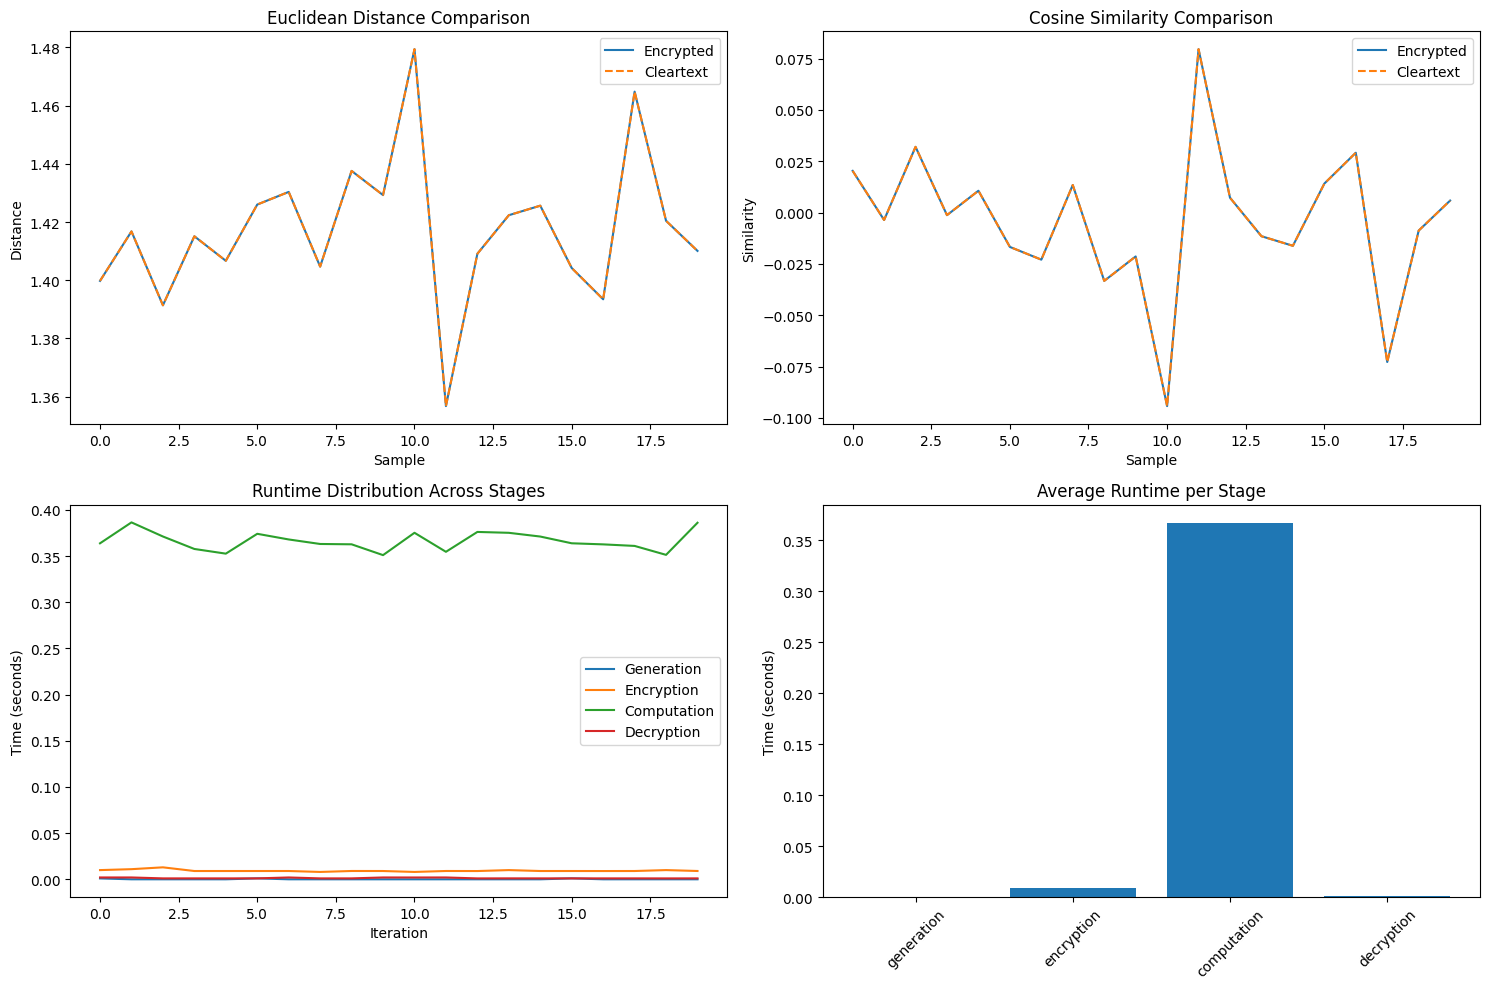


=== Final Demo ===
Euclidean Distance:
  Encrypted: 1.427550
  Cleartext: 1.427548
Cosine Similarity:
  Encrypted: -0.018950
  Cleartext: -0.018947


In [3]:
import time
import statistics
import numpy as np
import tenseal as ts
import matplotlib.pyplot as plt

# Configuration
VECTOR_DIM = 512
REPETITIONS = 20  # Reduced for practical testing
PLOT_SAMPLES = 50  # Number of samples to plot

# CKKS Context Setup
context = ts.context(
    ts.SCHEME_TYPE.CKKS,
    poly_modulus_degree=8192,
    coeff_mod_bit_sizes=[60, 40, 40, 60]
)
context.generate_galois_keys()
context.global_scale = 2 ** 40

def generate_normalized_vector():
    """Generate random vector and normalize it"""
    vec = np.random.randn(VECTOR_DIM)
    return vec / np.linalg.norm(vec)

def homomorphic_cosine_similarity(enc_vec1, enc_vec2):
    """Compute cosine similarity for normalized vectors (dot product)"""
    return enc_vec1.dot(enc_vec2)

def homomorphic_euclidean_distance(enc_vec1, enc_vec2):
    """Compute squared Euclidean distance for normalized vectors (2 - 2*dot)"""
    dot_product = enc_vec1.dot(enc_vec2)
    return 2 - 2 * dot_product

# Data collection structures
metrics = {
    'euclidean': {'encrypted': [], 'cleartext': [], 'difference': []},
    'cosine': {'encrypted': [], 'cleartext': [], 'difference': []},
    'timing': {
        'generation': [],
        'encryption': [],
        'computation': [],
        'decryption': []
    }
}

# Main evaluation loop
for _ in range(REPETITIONS):
    # Vector generation and normalization
    t_start = time.time()
    vec1 = generate_normalized_vector()
    vec2 = generate_normalized_vector()
    metrics['timing']['generation'].append(time.time() - t_start)
    
    # Encryption
    t_start = time.time()
    enc_vec1 = ts.ckks_vector(context, vec1)
    enc_vec2 = ts.ckks_vector(context, vec2)
    metrics['timing']['encryption'].append(time.time() - t_start)
    
    # Homomorphic computations
    t_start = time.time()
    enc_euc = homomorphic_euclidean_distance(enc_vec1, enc_vec2)
    enc_cos = homomorphic_cosine_similarity(enc_vec1, enc_vec2)
    metrics['timing']['computation'].append(time.time() - t_start)
    
    # Decryption and cleartext comparison
    t_start = time.time()
    # Cleartext calculations
    clear_cos = np.dot(vec1, vec2)
    clear_euc = np.linalg.norm(vec1 - vec2)
    
    # Decrypt and process encrypted results
    decrypted_euc_sq = enc_euc.decrypt()[0]
    decrypted_euc = np.sqrt(max(decrypted_euc_sq, 0))  # Handle potential negative values from noise
    decrypted_cos = enc_cos.decrypt()[0]
    
    # Store metrics
    metrics['euclidean']['encrypted'].append(decrypted_euc)
    metrics['euclidean']['cleartext'].append(clear_euc)
    metrics['euclidean']['difference'].append(abs(decrypted_euc - clear_euc))
    
    metrics['cosine']['encrypted'].append(decrypted_cos)
    metrics['cosine']['cleartext'].append(clear_cos)
    metrics['cosine']['difference'].append(abs(decrypted_cos - clear_cos))
    metrics['timing']['decryption'].append(time.time() - t_start)

# Visualization functions
def plot_metrics():
    plt.figure(figsize=(15, 10))
    
    # Euclidean Distance Comparison
    plt.subplot(2, 2, 1)
    plt.plot(metrics['euclidean']['encrypted'][:PLOT_SAMPLES], label='Encrypted')
    plt.plot(metrics['euclidean']['cleartext'][:PLOT_SAMPLES], '--', label='Cleartext')
    plt.title("Euclidean Distance Comparison")
    plt.xlabel("Sample")
    plt.ylabel("Distance")
    plt.legend()
    
    # Cosine Similarity Comparison
    plt.subplot(2, 2, 2)
    plt.plot(metrics['cosine']['encrypted'][:PLOT_SAMPLES], label='Encrypted')
    plt.plot(metrics['cosine']['cleartext'][:PLOT_SAMPLES], '--', label='Cleartext')
    plt.title("Cosine Similarity Comparison")
    plt.xlabel("Sample")
    plt.ylabel("Similarity")
    plt.legend()
    
    # Runtime Distribution
    plt.subplot(2, 2, 3)
    for stage in ['generation', 'encryption', 'computation', 'decryption']:
        plt.plot(metrics['timing'][stage], label=stage.capitalize())
    plt.title("Runtime Distribution Across Stages")
    plt.xlabel("Iteration")
    plt.ylabel("Time (seconds)")
    plt.legend()
    
    # Average Runtime
    plt.subplot(2, 2, 4)
    avg_times = [statistics.mean(metrics['timing'][stage]) for stage in metrics['timing']]
    plt.bar(metrics['timing'].keys(), avg_times)
    plt.title("Average Runtime per Stage")
    plt.ylabel("Time (seconds)")
    plt.xticks(rotation=45)
    
    plt.tight_layout()
    plt.show()

# Generate and display results
print("=== Accuracy Metrics ===")
for metric in ['euclidean', 'cosine']:
    avg_diff = statistics.mean(metrics[metric]['difference'])
    std_diff = statistics.pstdev(metrics[metric]['difference']) if len(metrics[metric]['difference']) > 1 else 0
    max_diff = max(metrics[metric]['difference'])
    print(f"{metric.capitalize()}:\n  Avg Difference: {avg_diff:.2e}\n  Std Dev: {std_diff:.2e}\n  Max Difference: {max_diff:.2e}\n")

print("=== Runtime Metrics ===")
for stage in metrics['timing']:
    avg_time = statistics.mean(metrics['timing'][stage])
    std_time = statistics.pstdev(metrics['timing'][stage]) if len(metrics['timing'][stage]) > 1 else 0
    print(f"{stage.capitalize()}:\n  Avg: {avg_time:.4f}s\n  Std Dev: {std_time:.4f}s\n")

# Generate visualizations
plot_metrics()

# Final demo
print("\n=== Final Demo ===")
demo_vec1 = generate_normalized_vector()
demo_vec2 = generate_normalized_vector()
enc_demo1 = ts.ckks_vector(context, demo_vec1)
enc_demo2 = ts.ckks_vector(context, demo_vec2)

# Homomorphic computations
enc_euc = homomorphic_euclidean_distance(enc_demo1, enc_demo2)
enc_cos = homomorphic_cosine_similarity(enc_demo1, enc_demo2)

# Decryption and processing
decrypted_euc_sq = enc_euc.decrypt()[0]
decrypted_euc = np.sqrt(max(decrypted_euc_sq, 0))
decrypted_cos = enc_cos.decrypt()[0]

# Cleartext calculations
clear_euc = np.linalg.norm(demo_vec1 - demo_vec2)
clear_cos = np.dot(demo_vec1, demo_vec2)

print(f"Euclidean Distance:\n  Encrypted: {decrypted_euc:.6f}\n  Cleartext: {clear_euc:.6f}")
print(f"Cosine Similarity:\n  Encrypted: {decrypted_cos:.6f}\n  Cleartext: {clear_cos:.6f}")